# MPS using the deesseX wrapper

The principle of deesseX is to fill the simulation grid by successively simulating sections with deesse (according the the given orientation) conditionally to the sections previously simulated. The name deesseX refers to crossing-simulation / X-simulation with deesse.

## Example - 3D simulation from 2D sections parallel to XY, XZ and YZ planes

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
import time
import os

# import package 'geone'
import geone as gn

In [2]:
pv.set_jupyter_backend('static') # to get static plots within the jupyter notebook

## Training image
In this example, the same TI will be used for simulating section parallel to XY, XZ or YZ plane.

Source of the image: *T. Zhang, P. Switzer, and A. Journel, Filter-based classification of training image patterns for spatial simulation, MATHEMATICAL GEOLOGY, 38(1):63-80, JAN 2006,[ doi:10.1007/s11004-005-9004-x](https://dx.doi.org/10.1007/s11004-005-9004-x).*

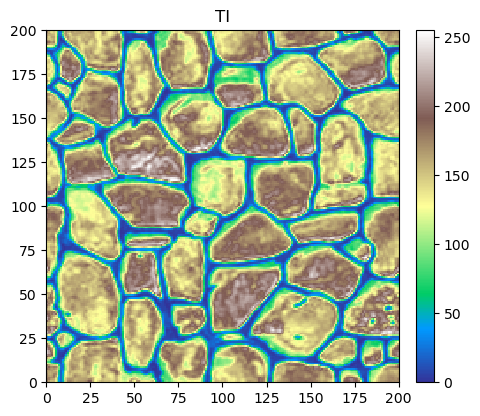

TI dimension: 200 x 200 x 1


In [3]:
data_dir = 'data' # directory containing the training image file
ti = gn.img.readImageGslib(os.path.join(data_dir, 'tiContinuous.gslib'))

# min and max values
vmin, vmax = ti.val.min(), ti.val.max()

# Plot 
plt.figure(figsize=(5,5))
gn.imgplot.drawImage2D(ti, cmap='terrain', title='TI')
#gn.imgplot.drawImage2D(ti, cmap='gray', title='TI')
plt.show()

print(f'TI dimension: {ti.nx} x {ti.ny} x {ti.nz}')

### Re-orient the TI
The TIs must be re-oriented with respect to the sections for which they will be used during the simulation.

In [4]:
# TI for XY section:
ti_xy = ti # keep the TI initially read

# TI for XZ section:
ti_xz = gn.img.copyImg(ti) # copy the TI initially read
ti_xz.permyz() # permutes axes y and z

# TI for YZ section:
ti_yz = gn.img.copyImg(ti) # copy the TI initially read
ti_yz.permxy() # permutes axes x and y
ti_yz.permxz() # permutes axes x and z

# # or equivalently
# ti_yz.permxz() # permutes axes x and z
# ti_yz.permyz() # permutes axes y and z

print(f'TI xy dimension: {ti_xy.nx} x {ti_xy.ny} x {ti_xy.nz}')
print(f'TI xz dimension: {ti_xz.nx} x {ti_xz.ny} x {ti_xz.nz}')
print(f'TI yz dimension: {ti_yz.nx} x {ti_yz.ny} x {ti_yz.nz}')

TI xy dimension: 200 x 200 x 1
TI xz dimension: 200 x 1 x 200
TI yz dimension: 1 x 200 x 200


Plot the TIs to be sure of their orientation in the desired plane. Check also the cell size.

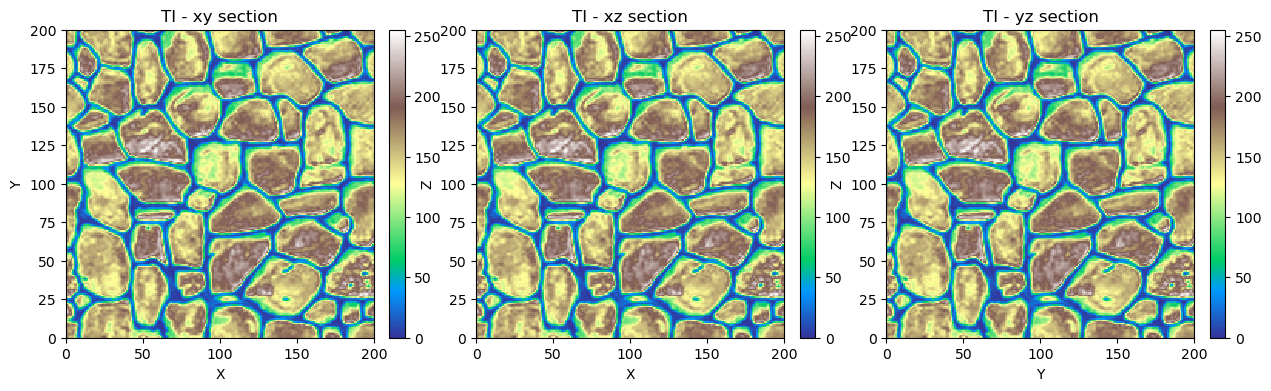

TI xy cell size: 1.0 x 1.0 x 1.0
TI xz cell size: 1.0 x 1.0 x 1.0
TI yz cell size: 1.0 x 1.0 x 1.0


In [5]:
categVal = [0, 1]
categCol = ['lightblue', 'orange']

# Figure
plt.subplots(1,3, figsize=(15,4))

plt.subplot(1,3,1)
gn.imgplot.drawImage2D(ti_xy, iz=0, xlabel='X', ylabel='Y', cmap='terrain')
plt.title('TI - xy section')

plt.subplot(1,3,2)
gn.imgplot.drawImage2D(ti_xz, iy=0, xlabel='X', ylabel='Z', cmap='terrain')
plt.title('TI - xz section')

plt.subplot(1,3,3)
gn.imgplot.drawImage2D(ti_yz, ix=0, xlabel='Y', ylabel='Z', cmap='terrain')
plt.title('TI - yz section')

plt.show()

print(f'TI xy cell size: {ti_xy.sx} x {ti_xy.sy} x {ti_xy.sz}')
print(f'TI xz cell size: {ti_xz.sx} x {ti_xz.sy} x {ti_xz.sz}')
print(f'TI yz cell size: {ti_yz.sx} x {ti_yz.sy} x {ti_yz.sz}')

## Defining simulation grid and variable(s)
These parameters will be used in the set up for deesseX further.

In [6]:
# Simulation grid (3D)
nx, ny, nz = 180, 20, 170
sx, sy, sz = 1.0, 1.0, 1.0
ox, oy, oz = 0.0, 0.0, 0.0

# Variable(s)
nv = 1
varname = 'code'
distanceType='continuous'

## Set up for deesseX
The input parameters required to run deesseX are specified with the following classes:
- `gn.deesseinterface.DeesseXInput`: general input
- `gn.deesseinterface.DeesseXInputSectionPath`: input defining the strategy of simulation, i.e. which type of sections (orientation) will be simulated and the section path (succession of sections)
- `gn.deesseinterface.DeesseXInputSection`: input defining the deesse parameters for one section type.

In [7]:
# Strategy of simulation
deesseX_input_section_path = gn.deesseinterface.DeesseXInputSectionPath(
    sectionMode='section_xy_xz_yz',
    sectionPathMode='section_path_subdiv'
)

# Deesse parameters for ...
# ... section parallel to xy plane
pyrGenParams_xy = gn.deesseinterface.PyramidGeneralParameters(
    npyramidLevel=3,                          # number of pyramid levels, additional to the simulation grid
    kx=[2, 2, 2], ky=[2, 2, 2], kz=[0, 0, 0]  # reduction factors from one level to the next one
                                              #    (kz=[0, 0, 0]: do not apply reduction along z axis)
)
pyrParams = gn.deesseinterface.PyramidParameters(
    nlevel=3,                        # number of levels
    pyramidType='continuous'         # type of pyramid
)
deesseX_input_section_xy = gn.deesseinterface.DeesseXInputSection(
    nx=nx, ny=ny, nz=nz, nv=nv, # dimension of the simulation grid (number of cells), number of variable(s)
    distanceType=distanceType,  # distance type
    sectionType='xy',           # section type for which the deesse parameters are defined
    TI=ti_xy,                   # TI (class gn.deesseinterface.Img)
    pyramidGeneralParameters=pyrGenParams_xy, # pyramid general parameters
    pyramidParameters=pyrParams,              # pyramid parameters for each variable
    nneighboringNode=64,        # max. number of neighbors (for the patterns)
    distanceThreshold=0.02,     # acceptation threshold (for distance between patterns)
    maxScanFraction=0.25,       # max. scanned fraction of the TI (for simulation of each cell)
    npostProcessingPathMax=1,   # number of post-processing path(s)
)

# ... section parallel to xz plane
pyrGenParams_xz = gn.deesseinterface.PyramidGeneralParameters(
    npyramidLevel=3,                          # number of pyramid levels, additional to the simulation grid
    kx=[2, 2, 2], ky=[0, 0, 0], kz=[2, 2, 2]  # reduction factors from one level to the next one
                                              #    (ky=[0, 0, 0]: do not apply reduction along y axis)
)
# (same pyramid paramters for variable)
deesseX_input_section_xz = gn.deesseinterface.DeesseXInputSection(
    nx=nx, ny=ny, nz=nz, nv=nv, # dimension of the simulation grid (number of cells), number of variable(s)
    distanceType=distanceType,  # distance type
    sectionType='xz',           # section type for which the deesse parameters are defined
    TI=ti_xz,                   # TI (class gn.deesseinterface.Img)
    pyramidGeneralParameters=pyrGenParams_xz, # pyramid general parameters
    pyramidParameters=pyrParams,              # pyramid parameters for each variable
    nneighboringNode=64,        # max. number of neighbors (for the patterns)
    distanceThreshold=0.02,     # acceptation threshold (for distance between patterns)
    maxScanFraction=0.25,       # max. scanned fraction of the TI (for simulation of each cell)
    npostProcessingPathMax=1,   # number of post-processing path(s)
)

# ... section parallel to yz plane
pyrGenParams_yz = gn.deesseinterface.PyramidGeneralParameters(
    npyramidLevel=3,                          # number of pyramid levels, additional to the simulation grid
    kx=[0, 0, 0], ky=[2, 2, 2], kz=[2, 2, 2]  # reduction factors from one level to the next one
                                              #    (kx=[0, 0, 0]: do not apply reduction along x axis)
)
# (same pyramid paramters for variable)
deesseX_input_section_yz = gn.deesseinterface.DeesseXInputSection(
    nx=nx, ny=ny, nz=nz, nv=nv, # dimension of the simulation grid (number of cells), number of variable(s)
    distanceType=distanceType,  # distance type
    sectionType='yz',           # section type for which the deesse parameters are defined
    TI=ti_yz,                   # TI (class gn.deesseinterface.Img)
    pyramidGeneralParameters=pyrGenParams_yz, # pyramid general parameters
    pyramidParameters=pyrParams,              # pyramid parameters for each variable
    nneighboringNode=64,        # max. number of neighbors (for the patterns)
    distanceThreshold=0.02,     # acceptation threshold (for distance between patterns)
    maxScanFraction=0.25,       # max. scanned fraction of the TI (for simulation of each cell)
    npostProcessingPathMax=1,   # number of post-processing path(s)
)

# Main input for deesseX
deesseX_input = gn.deesseinterface.DeesseXInput(
    nx=nx, ny=ny, nz=nz,        # dimension of the simulation grid (number of cells)
    sx=sx, sy=sy, sz=sz,        # cells units in the simulation grid (here are the default values)
    ox=ox, oy=oy, oz=oz,        # origin of the simulation grid (here are the default values)
    nv=nv, varname=varname,     # number of variable(s), name of the variable(s)
    distanceType=distanceType,  # distance type: proportion of mismatching nodes (categorical var., default)
    sectionPath_parameters=deesseX_input_section_path, 
                                # section path (defining the succession of section to be simulated)
                                # (class gn.deesseinterface.DeesseXInputSectionPath)
    section_parameters=[deesseX_input_section_xy, deesseX_input_section_xz, deesseX_input_section_yz],
                                # simulation parameters for each section type
                                # (sequence of class gn.deesseinterface.DeesseXInputSection)
    outputSectionTypeFlag=True, # retrieve section type map in output
    outputSectionStepFlag=True, # retrieve section step map in output
    seed=444,                   # seed (initialization of the random number generator)
    nrealization=2)             # number of realization(s)

## Launching deesseX

In [8]:
# Run deesseX
t1 = time.time() # start time
deesseX_output = gn.deesseinterface.deesseXRun_mp(deesseX_input)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

X-DeeSse running... [VERSION 1.0 / BUILD NUMBER 20230411 / OpenMP 9 thread(s)]
DeeSseX running on 2 process(es)... [VERSION 1.0 / BUILD NUMBER 20230411 / OpenMP 9 thread(s)]
* checking out license OK.
* checking out license OK.
DeeSseX run complete (all process(es))
Elapsed time: 57 sec


## Retrieve the results (and display)

../src/intel/isl/isl.c:2216: FINISHME: ../src/intel/isl/isl.c:isl_surf_supports_ccs: CCS for 3D textures is disabled, but a workaround is available.


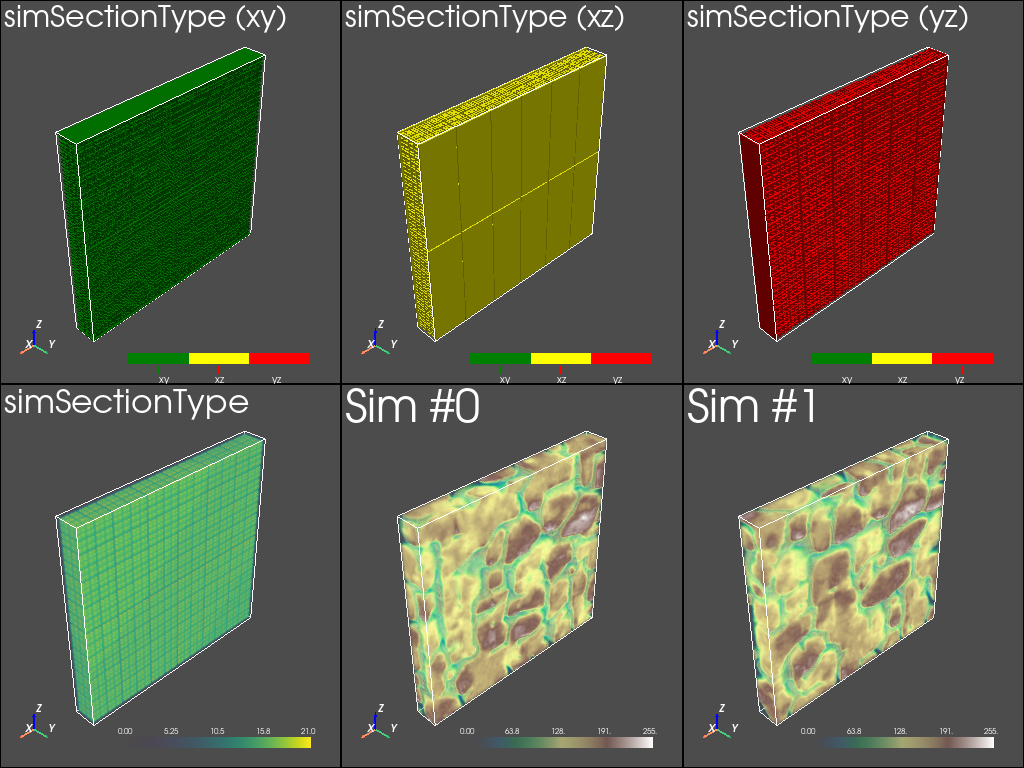

In [9]:
# Retrieve the results
sim = deesseX_output['sim']
simSectionType = deesseX_output['simSectionType'][0] # only one section type map
simSectionStep = deesseX_output['simSectionStep'][0] # only one section step map

# Gather all the realizations into one image
all_sim = gn.img.gatherImages(sim) # all_sim is one image with nreal variables

# value and color of section type 
categValSectType = [0, 1, 2] # value of the section type id (0: xy, 1: xz, 2: yz)
categColSectType = ['green', 'yellow', 'red'] # color for section type

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,3), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,3))

for i, (active, type_str) in enumerate(zip(
        [[True, False, False], [False, True, False], [False, False, True]], ['xy', 'xz', 'yz']
    )):
    pp.subplot(0,i)
    gn.imgplot3d.drawImage3D_surface(simSectionType, plotter=pp,
        categ=True,
        categVal=categValSectType,
        categCol=categColSectType,
        categActive=active, # display only category value (in categVal) with True
        alpha=1, # transparency (alpha channel)
        scalar_bar_annotations={0.5:'xy', 1.5:'xz', 2.5:'yz'}, # (add 0.5 to center the label)
        scalar_bar_kwargs={'title':(i+1)*' ', 'vertical':False}, # distinct title in each subplot 
                                                                #    for correct display!
        text=f'simSectionType ({type_str})')

pp.subplot(1,0)
gn.imgplot3d.drawImage3D_volume(simSectionStep, plotter=pp,
    scalar_bar_kwargs={'title':5*' ', 'vertical':False}, # distinct title in each subplot for correct display!
    text='simSectionType')

for i in range(2):
    pp.subplot(1,i+1)
    gn.imgplot3d.drawImage3D_volume(all_sim, plotter=pp,
        iv=i,
        cmap='terrain', cmin=vmin, cmax=vmax,
        scalar_bar_kwargs={'title':(i+6)*' ', 'vertical':False},
        text=f'Sim #{i}')

pp.link_views()
pp.show()

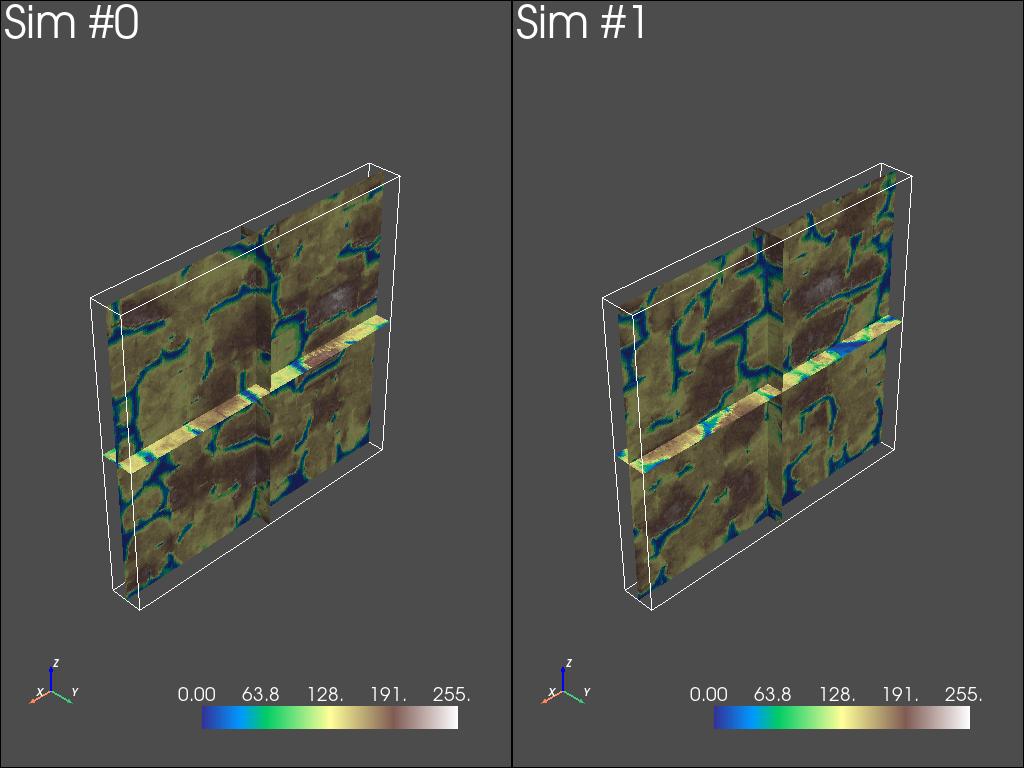

In [10]:
# Plot some slices
# Slices orthogonal to the axes, going through the center of the images
cx = all_sim.ox + 0.5 * all_sim.nx * all_sim.sx # center along x
cy = all_sim.oy + 0.5 * all_sim.ny * all_sim.sy # center along y
cz = all_sim.oz + 0.5 * all_sim.nz * all_sim.sz # center along z

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(1,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(1,2))

for i in range(2):
    pp.subplot(0,i)
    gn.imgplot3d.drawImage3D_slice(all_sim, plotter=pp,
        slice_normal_x=cx, 
        slice_normal_y=cy, 
        slice_normal_z=cz,
        iv=i,
        cmap='terrain', cmin=vmin, cmax=vmax,
        scalar_bar_kwargs={'title':(i+1)*' ', 'vertical':False},
        text=f'Sim #{i}')

pp.link_views()
pp.show()

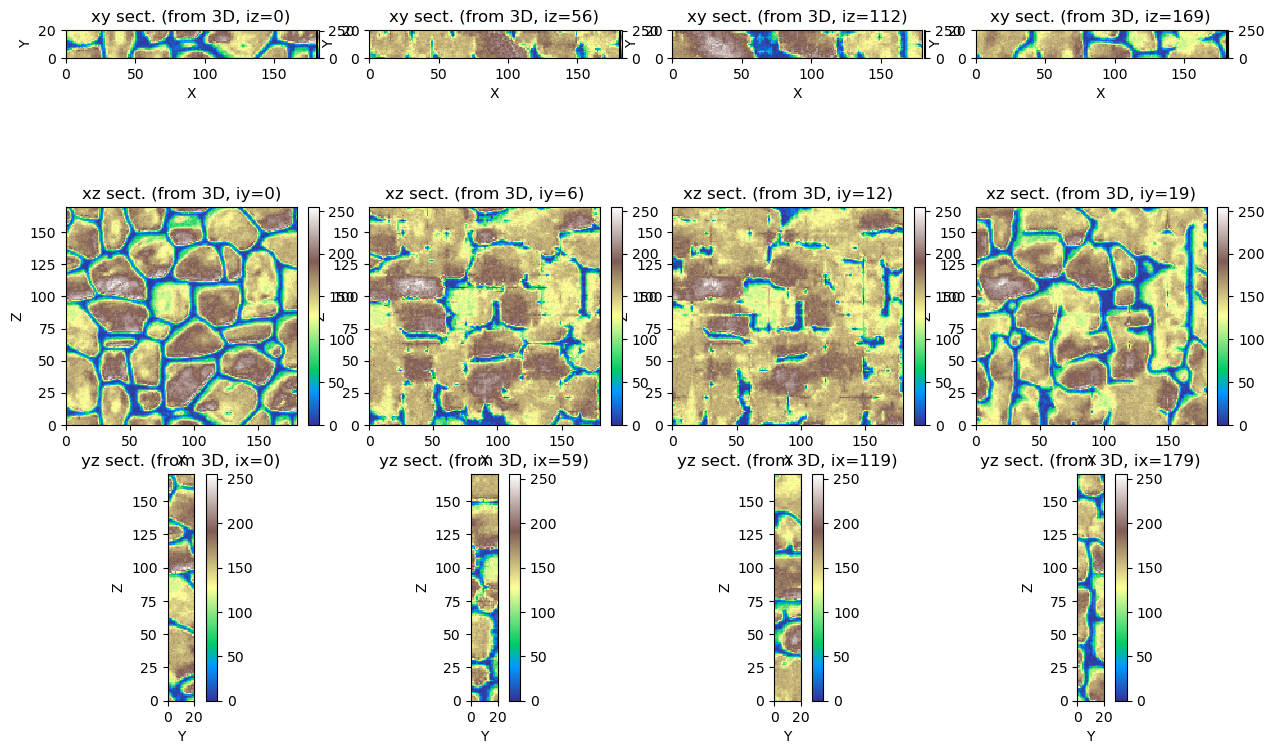

In [11]:
# Plot some slices in 2D
ix = np.asarray(np.linspace(0, all_sim.nx-1, 4), dtype='int') # indexes of section orthogonal to x-axis
iy = np.asarray(np.linspace(0, all_sim.ny-1, 4), dtype='int') # indexes of section orthogonal to y-axis
iz = np.asarray(np.linspace(0, all_sim.nz-1, 4), dtype='int') # indexes of section orthogonal to z-axis

iv = 0 # real index

plt.subplots(3,4, figsize=(15,10))

k = 1
for i in iz:
    plt.subplot(3,4,k)
    gn.imgplot.drawImage2D(all_sim, iv=iv, iz=i, cmap='terrain', vmin=vmin, vmax=vmax,
                           xlabel='X', ylabel='Y')
    plt.title(f'xy sect. (from 3D, iz={i})')
    k = k+1

for i in iy:
    plt.subplot(3,4,k)
    gn.imgplot.drawImage2D(all_sim, iv=iv, iy=i, cmap='terrain', vmin=vmin, vmax=vmax,
                           xlabel='X', ylabel='Z')
    plt.title(f'xz sect. (from 3D, iy={i})')
    k = k+1

for i in ix:
    plt.subplot(3,4,k)
    gn.imgplot.drawImage2D(all_sim, iv=iv, ix=i, cmap='terrain', vmin=vmin, vmax=vmax,
                           xlabel='Y', ylabel='Z')
    plt.title(f'yz sect. (from 3D, ix={i})')
    k = k+1

plt.show()

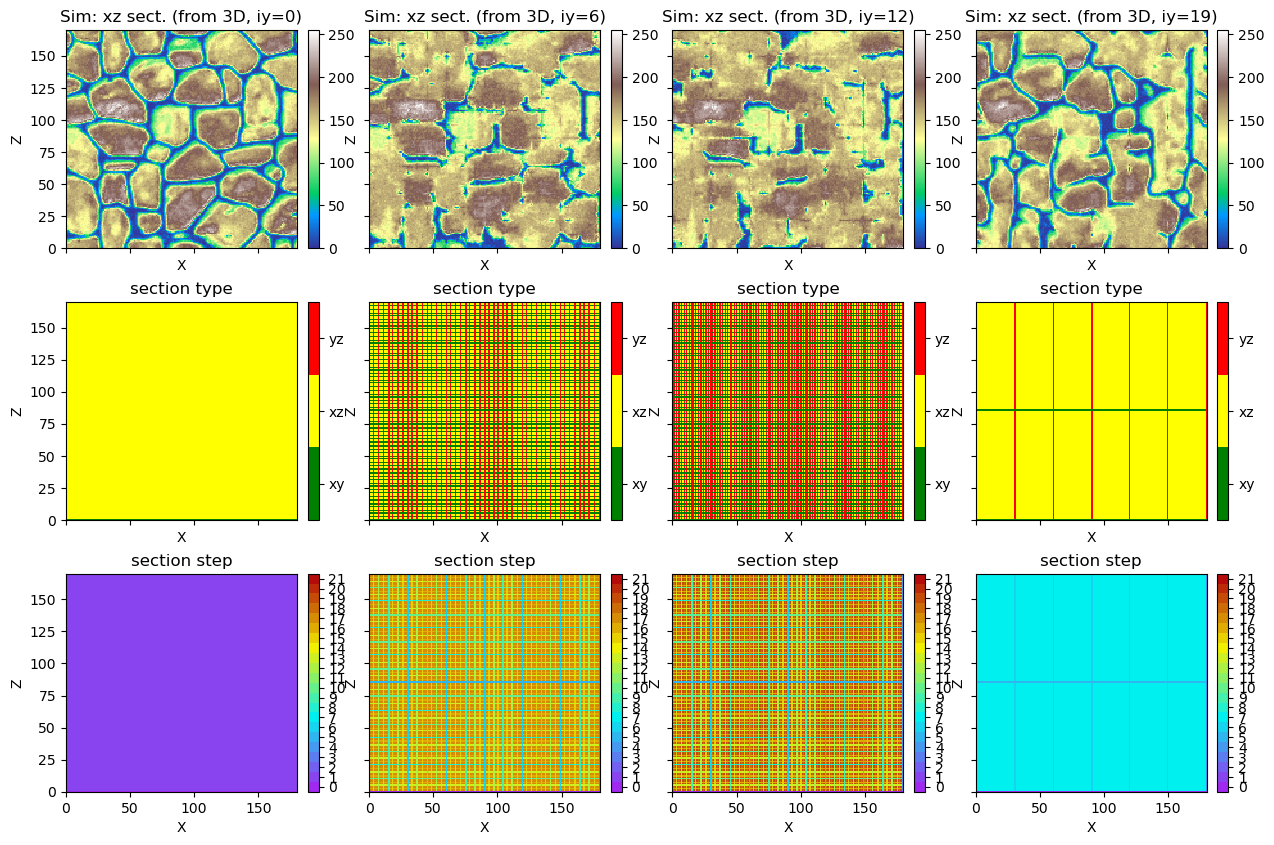

In [12]:
# Plot some slices in 2D - xz section
iy = np.asarray(np.linspace(0, all_sim.ny-1, 4), dtype='int') # indexes of section orthogonal to y-axis

iv = 0 # real index

plt.subplots(3,4, figsize=(15,10), sharex=True, sharey=True)

k = 1
for i in iy:
    plt.subplot(3,4,k)
    gn.imgplot.drawImage2D(all_sim, iv=iv, iy=i, cmap='terrain', vmin=vmin, vmax=vmax,
                           categVal=categVal, categCol=categCol,
                           xlabel='X', ylabel='Z')
    plt.title(f'Sim: xz sect. (from 3D, iy={i})')
    k = k+1

for i in iy:
    plt.subplot(3,4,k)
    gn.imgplot.drawImage2D(simSectionType, iy=i, categ=True, 
                           categVal=categValSectType, categCol=categColSectType,
                           cticklabels=['xy', 'xz', 'yz'],
                           xlabel='X', ylabel='Z')
    plt.title('section type')
    k = k+1

for i in iy:
    plt.subplot(3,4,k)
    gn.imgplot.drawImage2D(simSectionStep, iy=i, categ=True,
                           categVal=np.arange(0, np.max(simSectionStep.val) + 1),
                           xlabel='X', ylabel='Z')
    plt.title('section step')
    k = k+1

plt.show()

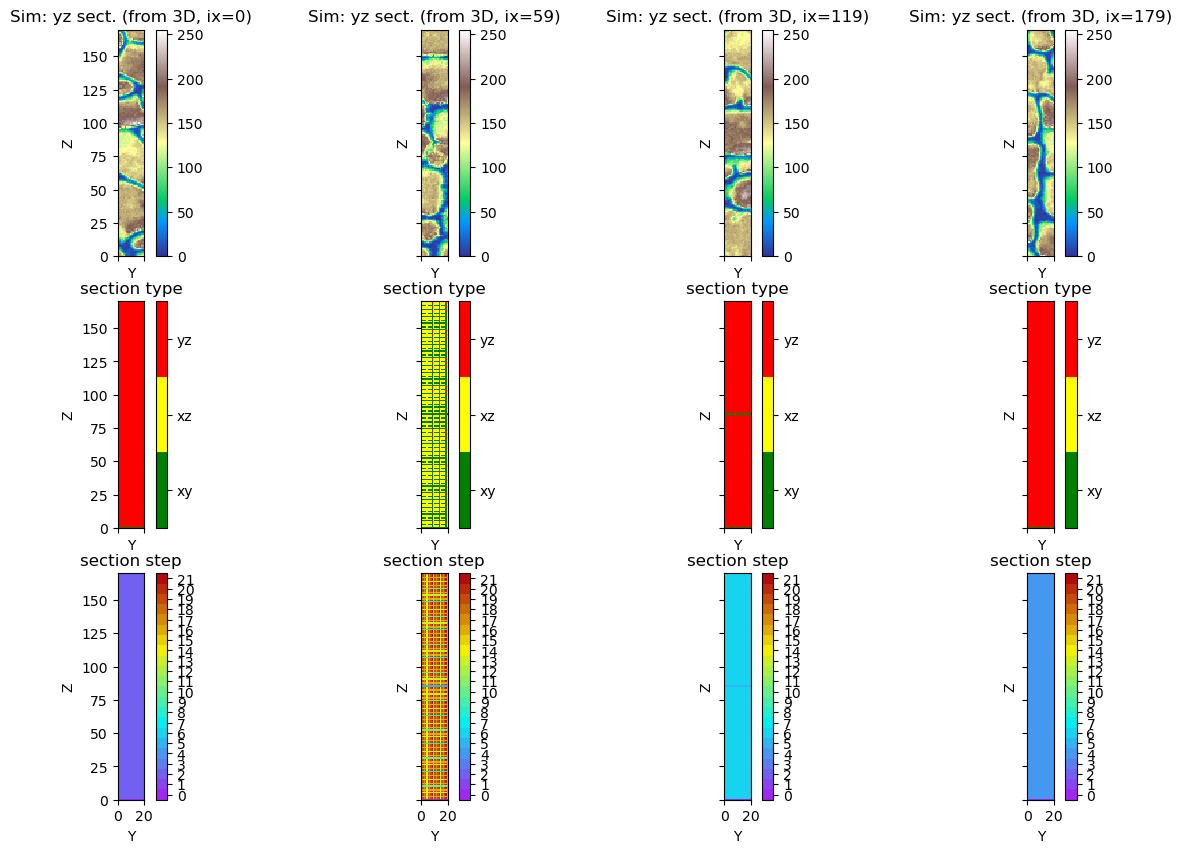

In [13]:
# Plot some slices in 2D - yz section
ix = np.asarray(np.linspace(0, all_sim.nx-1, 4), dtype='int') # indexes of section orthogonal to x-axis

iv = 0 # real index

plt.subplots(3,4, figsize=(15,10), sharex=True, sharey=True)

k = 1
for i in ix:
    plt.subplot(3,4,k)
    gn.imgplot.drawImage2D(all_sim, iv=iv, ix=i, cmap='terrain', vmin=vmin, vmax=vmax,
                           xlabel='Y', ylabel='Z')
    plt.title(f'Sim: yz sect. (from 3D, ix={i})')
    k = k+1

for i in ix:
    plt.subplot(3,4,k)
    gn.imgplot.drawImage2D(simSectionType, ix=i, categ=True, 
                           categVal=categValSectType, categCol=categColSectType,
                           cticklabels=['xy', 'xz', 'yz'],
                           xlabel='Y', ylabel='Z')
    plt.title('section type')
    k = k+1

for i in ix:
    plt.subplot(3,4,k)
    gn.imgplot.drawImage2D(simSectionStep, ix=i, categ=True,
                           categVal=np.arange(0, np.max(simSectionStep.val) + 1),
                           xlabel='Y', ylabel='Z')
    plt.title('section step')
    k = k+1

plt.show()

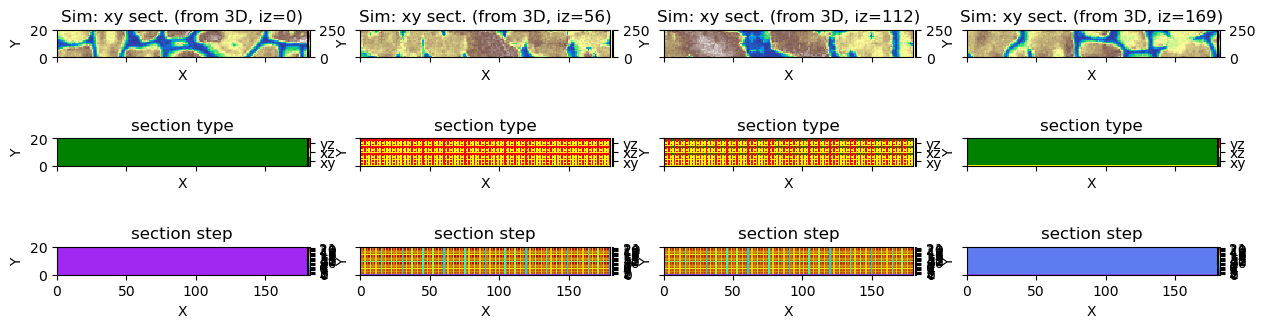

In [14]:
# Plot some slices in 2D - xy section
iz = np.asarray(np.linspace(0, all_sim.nz-1, 4), dtype='int') # indexes of section orthogonal to z-axis

iv = 0 # real index

plt.subplots(3,4, figsize=(15,4), sharex=True, sharey=True)

k = 1
for i in iz:
    plt.subplot(3,4,k)
    gn.imgplot.drawImage2D(all_sim, iv=iv, iz=i, cmap='terrain', vmin=vmin, vmax=vmax,
                           categVal=categVal, categCol=categCol,
                           xlabel='X', ylabel='Y')
    plt.title(f'Sim: xy sect. (from 3D, iz={i})')
    k = k+1

for i in iz:
    plt.subplot(3,4,k)
    gn.imgplot.drawImage2D(simSectionType, iz=i, categ=True, 
                           categVal=categValSectType, categCol=categColSectType,
                           cticklabels=['xy', 'xz', 'yz'],
                           xlabel='X', ylabel='Y')
    plt.title('section type')
    k = k+1

for i in iz:
    plt.subplot(3,4,k)
    gn.imgplot.drawImage2D(simSectionStep, iz=i, categ=True,
                           categVal=np.arange(0, np.max(simSectionStep.val) + 1),
                           xlabel='X', ylabel='Y')
    plt.title('section step')
    k = k+1

plt.show()

### Trick - smoothing result
Applying a moving average on the entire 3D simulation grid using a $3\times 3\times 3$ kernel (via the function `geone.deesseinterface.imgPyramidImage`) allows to "smooth" the results.

In [15]:
#all_sim_smooth = gn.deesseinterface.imgPyramidImage(all_sim, operation='reduce', kx=0, ky=1, kz=1)
#all_sim_smooth = gn.deesseinterface.imgPyramidImage(all_sim_smooth, operation='reduce', kx=1, ky=0, kz=0)
all_sim_smooth = gn.deesseinterface.imgPyramidImage(all_sim, operation='reduce', kx=1, ky=1, kz=1)


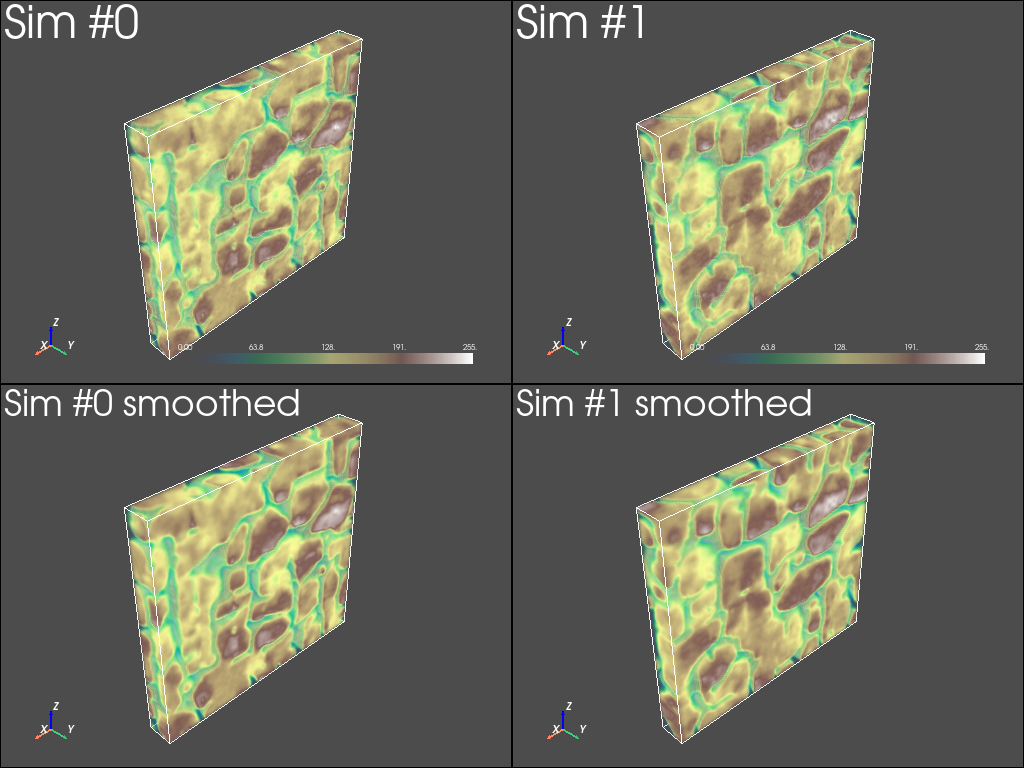

In [16]:
# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

for i in range(2):
    pp.subplot(0,i)
    gn.imgplot3d.drawImage3D_volume(all_sim, plotter=pp,
        iv=i,
        cmap='terrain', cmin=vmin, cmax=vmax,
        scalar_bar_kwargs={'title':(i+6)*' ', 'vertical':False},
        text=f'Sim #{i}')

for i in range(2):
    pp.subplot(1,i)
    gn.imgplot3d.drawImage3D_volume(all_sim_smooth, plotter=pp,
        iv=i,
        cmap='terrain', cmin=vmin, cmax=vmax,
        scalar_bar_kwargs={'title':(i+6)*' ', 'vertical':False},
        text=f'Sim #{i} smoothed')

    pp.link_views()
pp.show()

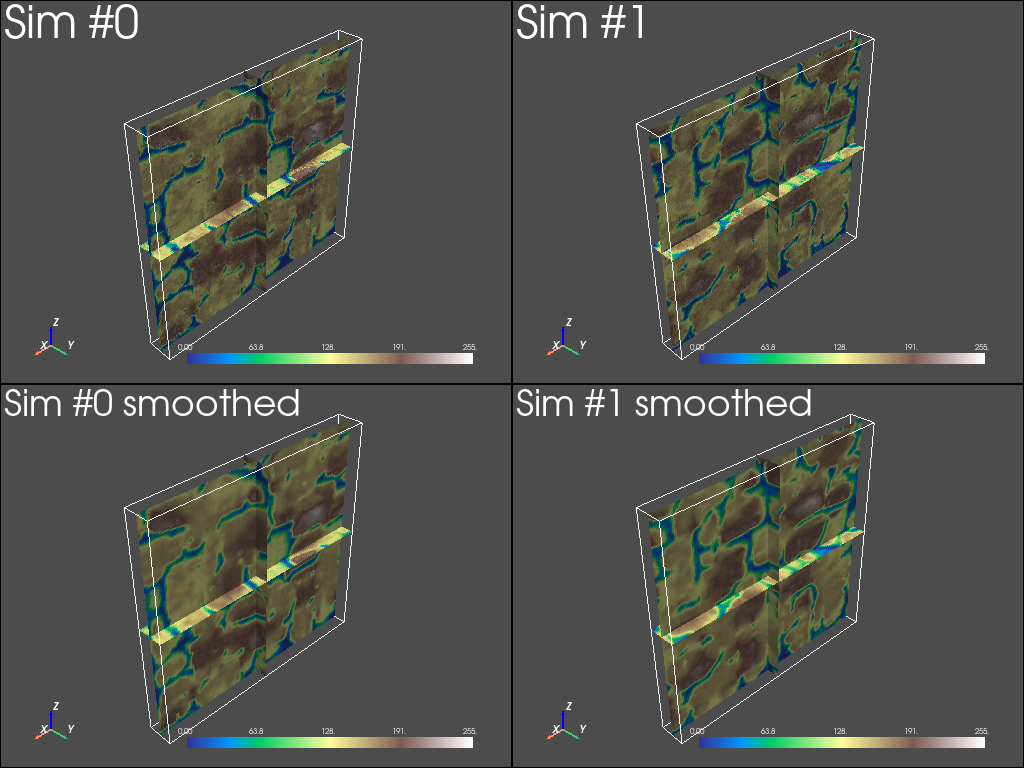

In [17]:
# Plot some slices
# Slices orthogonal to the axes, going through the center of the images
cx = all_sim.ox + 0.5 * all_sim.nx * all_sim.sx # center along x
cy = all_sim.oy + 0.5 * all_sim.ny * all_sim.sy # center along y
cz = all_sim.oz + 0.5 * all_sim.nz * all_sim.sz # center along z

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

for i in range(2):
    pp.subplot(0,i)
    gn.imgplot3d.drawImage3D_slice(all_sim, plotter=pp,
        slice_normal_x=cx, 
        slice_normal_y=cy, 
        slice_normal_z=cz,
        iv=i,
        cmap='terrain', cmin=vmin, cmax=vmax,
        scalar_bar_kwargs={'title':(i+1)*' ', 'vertical':False},
        text=f'Sim #{i}')

for i in range(2):
    pp.subplot(1,i)
    gn.imgplot3d.drawImage3D_slice(all_sim_smooth, plotter=pp,
        slice_normal_x=cx, 
        slice_normal_y=cy, 
        slice_normal_z=cz,
        iv=i,
        cmap='terrain', cmin=vmin, cmax=vmax,
        scalar_bar_kwargs={'title':(i+3)*' ', 'vertical':False},
        text=f'Sim #{i} smoothed')

    pp.link_views()
pp.show()

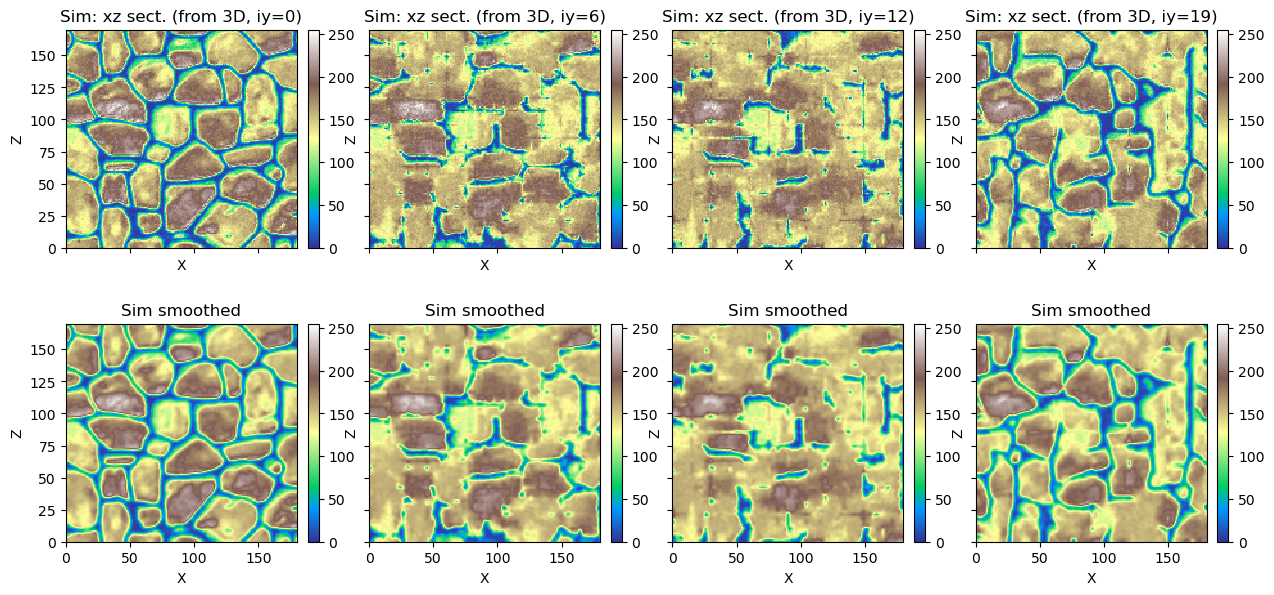

In [18]:
# Plot some slices in 2D - xz section
iy = np.asarray(np.linspace(0, all_sim.ny-1, 4), dtype='int') # indexes of section orthogonal to y-axis

iv = 0 # real index

plt.subplots(2,4, figsize=(15,7), sharex=True, sharey=True)

k = 1
for i in iy:
    plt.subplot(2,4,k)
    gn.imgplot.drawImage2D(all_sim, iv=iv, iy=i, cmap='terrain', vmin=vmin, vmax=vmax,
                           categVal=categVal, categCol=categCol,
                           xlabel='X', ylabel='Z')
    plt.title(f'Sim: xz sect. (from 3D, iy={i})')
    k = k+1

for i in iy:
    plt.subplot(2,4,k)
    gn.imgplot.drawImage2D(all_sim_smooth, iv=iv, iy=i, cmap='terrain', vmin=vmin, vmax=vmax,
                           categVal=categVal, categCol=categCol,
                           xlabel='X', ylabel='Z')
    plt.title(f'Sim smoothed')
    k = k+1

plt.show()

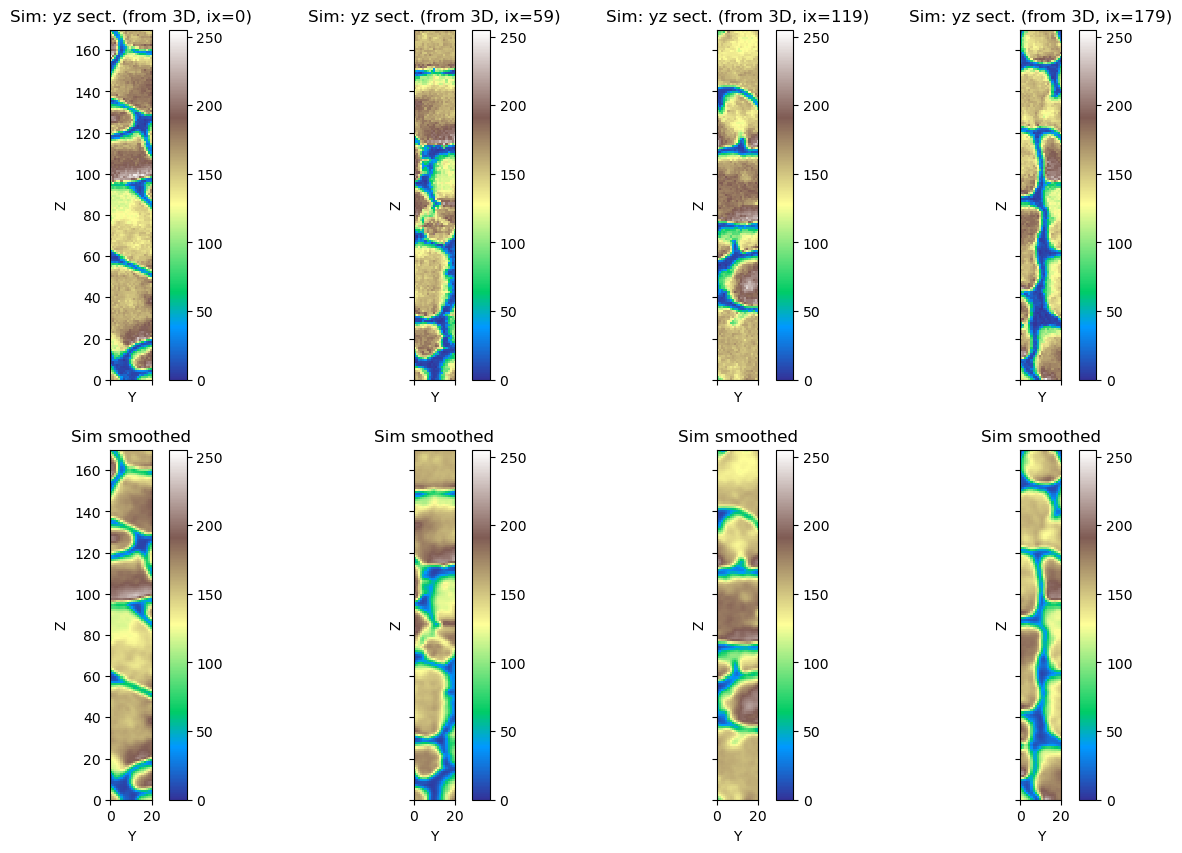

In [19]:
# Plot some slices in 2D - yz section
ix = np.asarray(np.linspace(0, all_sim.nx-1, 4), dtype='int') # indexes of section orthogonal to x-axis

iv = 0 # real index

plt.subplots(2,4, figsize=(15,10), sharex=True, sharey=True)

k = 1
for i in ix:
    plt.subplot(2,4,k)
    gn.imgplot.drawImage2D(all_sim, iv=iv, ix=i, cmap='terrain', vmin=vmin, vmax=vmax,
                           xlabel='Y', ylabel='Z')
    plt.title(f'Sim: yz sect. (from 3D, ix={i})')
    k = k+1

for i in ix:
    plt.subplot(2,4,k)
    gn.imgplot.drawImage2D(all_sim_smooth, iv=iv, ix=i, cmap='terrain', vmin=vmin, vmax=vmax,
                           xlabel='Y', ylabel='Z')
    plt.title(f'Sim smoothed')
    k = k+1

plt.show()

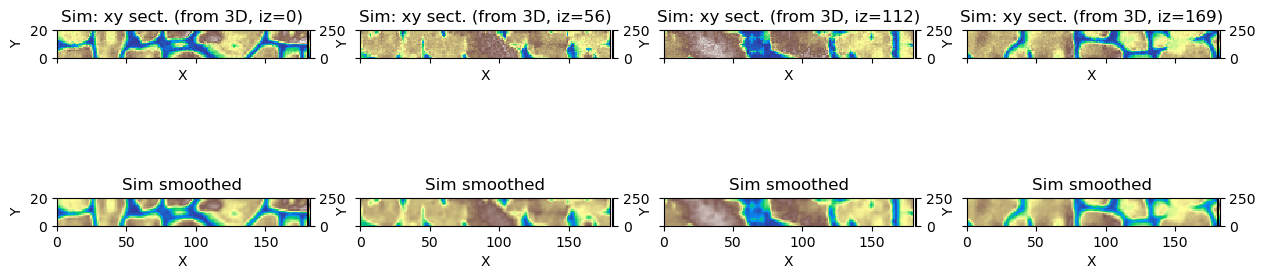

In [20]:
# Plot some slices in 2D - xy section
iz = np.asarray(np.linspace(0, all_sim.nz-1, 4), dtype='int') # indexes of section orthogonal to z-axis

iv = 0 # real index

plt.subplots(2,4, figsize=(15,4), sharex=True, sharey=True)

k = 1
for i in iz:
    plt.subplot(2,4,k)
    gn.imgplot.drawImage2D(all_sim, iv=iv, iz=i, cmap='terrain', vmin=vmin, vmax=vmax,
                           categVal=categVal, categCol=categCol,
                           xlabel='X', ylabel='Y')
    plt.title(f'Sim: xy sect. (from 3D, iz={i})')
    k = k+1

for i in iz:
    plt.subplot(2,4,k)
    gn.imgplot.drawImage2D(all_sim_smooth, iv=iv, iz=i, cmap='terrain', vmin=vmin, vmax=vmax,
                           categVal=categVal, categCol=categCol,
                           xlabel='X', ylabel='Y')
    plt.title(f'Sim smoothed')
    k = k+1

plt.show()

## Playing with homothety and rotation

- Allows any rotation in xy plane to enrich the TI for that section type
- Set homothety ratio along x and y to 2.0, to generate structures more elongated horizontally

In [21]:
# Strategy of simulation
deesseX_input_section_path = gn.deesseinterface.DeesseXInputSectionPath(
    sectionMode='section_xy_xz_yz',
    sectionPathMode='section_path_subdiv'
)

# Deesse parameters for ...
# ... section parallel to xy plane
pyrGenParams_xy = gn.deesseinterface.PyramidGeneralParameters(
    npyramidLevel=3,
    kx=[2, 2, 2], ky=[2, 2, 2], kz=[0, 0, 0]
)
pyrParams = gn.deesseinterface.PyramidParameters(
    nlevel=3,
    pyramidType='continuous'
)
deesseX_input_section_xy = gn.deesseinterface.DeesseXInputSection(
    nx=nx, ny=ny, nz=nz, nv=nv,
    distanceType=distanceType,
    sectionType='xy',
    TI=ti_xy,
    homothetyUsage=1,           # use homothety (scaling)
    homothetyXLocal=False,      #    along x: global homothety
    homothetyXRatio=2.0,        #    along x: value for scaling factor
    homothetyYLocal=False,      #    along y: global homothety
    homothetyYRatio=2.0,        #    along y: value for scaling factor
    rotationUsage=2,            # use rotation with tolerance
    rotationAzimuthLocal=False, #    rotation according to azimuth: global
    rotationAzimuth=[0., 360.], #    rotation azimuth: min and max values
    pyramidGeneralParameters=pyrGenParams_xy,
    pyramidParameters=pyrParams,
    nneighboringNode=64,
    distanceThreshold=0.02,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
)

# ... section parallel to xz plane
pyrGenParams_xz = gn.deesseinterface.PyramidGeneralParameters(
    npyramidLevel=3,
    kx=[2, 2, 2], ky=[0, 0, 0], kz=[2, 2, 2]
)
deesseX_input_section_xz = gn.deesseinterface.DeesseXInputSection(
    nx=nx, ny=ny, nz=nz, nv=nv,
    distanceType=distanceType,
    sectionType='xz',
    TI=ti_xz,
    homothetyUsage=1,           # use homothety (scaling)
    homothetyXLocal=False,      #    along x: global homothety
    homothetyXRatio=2.0,        #    along x: value for scaling factor
    pyramidGeneralParameters=pyrGenParams_xz,
    pyramidParameters=pyrParams,
    nneighboringNode=64,
    distanceThreshold=0.02,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
)

# ... section parallel to yz plane
pyrGenParams_yz = gn.deesseinterface.PyramidGeneralParameters(
    npyramidLevel=3,
    kx=[0, 0, 0], ky=[2, 2, 2], kz=[2, 2, 2]
)
deesseX_input_section_yz = gn.deesseinterface.DeesseXInputSection(
    nx=nx, ny=ny, nz=nz, nv=nv,
    distanceType=distanceType,
    sectionType='yz',
    TI=ti_yz,
    homothetyUsage=1,           # use homothety (scaling)
    homothetyYLocal=False,      #    along y: global homothety
    homothetyYRatio=2.0,        #    along y: value for scaling factor
    pyramidGeneralParameters=pyrGenParams_yz,
    pyramidParameters=pyrParams,
    nneighboringNode=64,
    distanceThreshold=0.02,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
)

# Main input for deesseX
deesseX_input = gn.deesseinterface.DeesseXInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=nv, varname=varname,
    distanceType=distanceType,
    sectionPath_parameters=deesseX_input_section_path, 
    section_parameters=[deesseX_input_section_xy, deesseX_input_section_xz, deesseX_input_section_yz],
    #outputSectionTypeFlag=True,
    #outputSectionStepFlag=True,
    seed=444,
    nrealization=1)

### Launching deesseX

In [22]:
# Run deesseX
t1 = time.time() # start time
deesseX_output = gn.deesseinterface.deesseXRun(deesseX_input)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

DeeSseX running... [VERSION 1.0 / BUILD NUMBER 20230411 / OpenMP 19 thread(s)]
* checking out license OK.
DeeSseX run complete
Elapsed time: 30 sec


### Retrieve the results (and display)

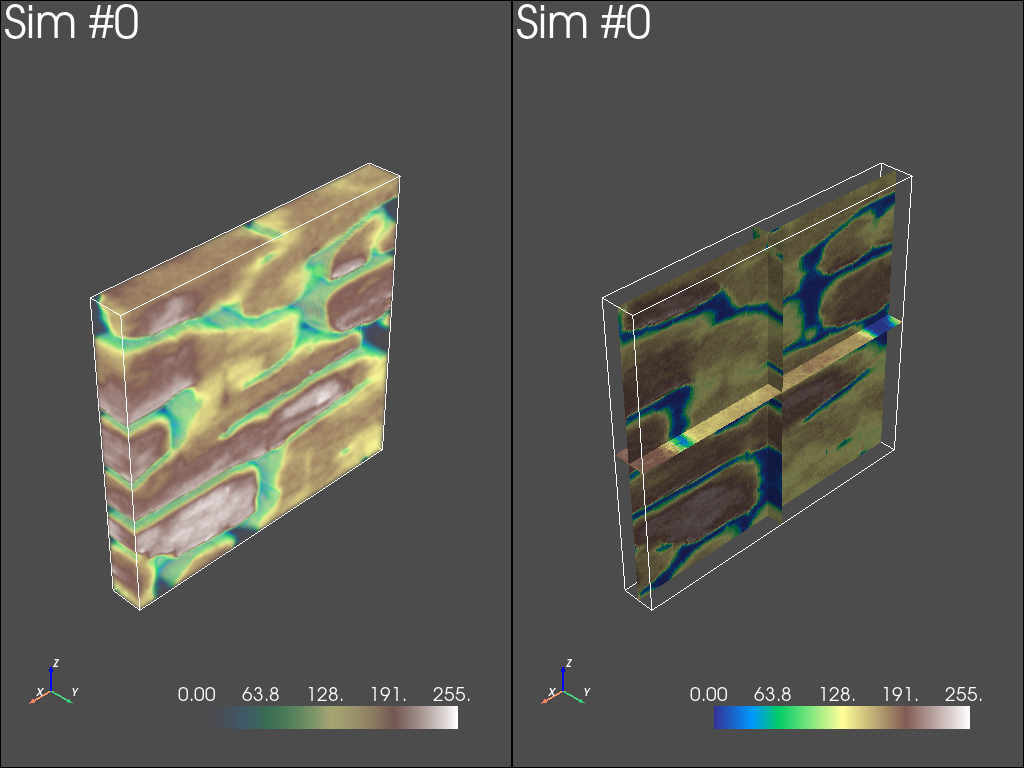

In [23]:
# Retrieve the results
sim = deesseX_output['sim'][0]

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(1,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(1,2))

pp.subplot(0,0)
gn.imgplot3d.drawImage3D_volume(sim, plotter=pp,
    cmap='terrain', cmin=vmin, cmax=vmax,
    scalar_bar_kwargs={'title':' ', 'vertical':False},
    text=f'Sim #{0}')

pp.subplot(0,1)
gn.imgplot3d.drawImage3D_slice(sim, plotter=pp,
    slice_normal_x=cx, 
    slice_normal_y=cy, 
    slice_normal_z=cz,
    cmap='terrain', cmin=vmin, cmax=vmax,
    scalar_bar_kwargs={'title':'  ', 'vertical':False},
    text=f'Sim #{0}')

pp.link_views()
pp.show()

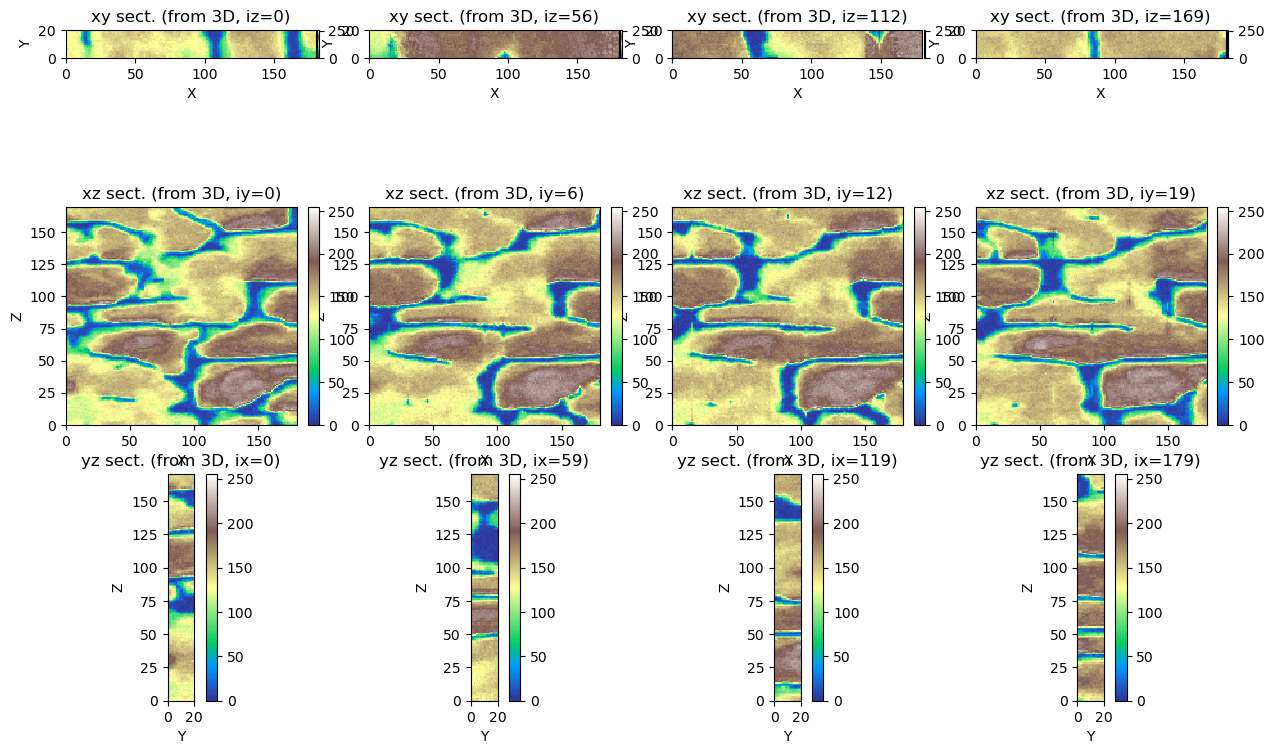

In [24]:
# Plot some slices in 2D
ix = np.asarray(np.linspace(0, sim.nx-1, 4), dtype='int') # indexes of section orthogonal to x-axis
iy = np.asarray(np.linspace(0, sim.ny-1, 4), dtype='int') # indexes of section orthogonal to y-axis
iz = np.asarray(np.linspace(0, sim.nz-1, 4), dtype='int') # indexes of section orthogonal to z-axis

iv = 0 # real index

plt.subplots(3,4, figsize=(15,10))

k = 1
for i in iz:
    plt.subplot(3,4,k)
    gn.imgplot.drawImage2D(sim, iv=iv, iz=i, cmap='terrain', vmin=vmin, vmax=vmax,
                           xlabel='X', ylabel='Y')
    plt.title(f'xy sect. (from 3D, iz={i})')
    k = k+1

for i in iy:
    plt.subplot(3,4,k)
    gn.imgplot.drawImage2D(sim, iv=iv, iy=i, cmap='terrain', vmin=vmin, vmax=vmax,
                           xlabel='X', ylabel='Z')
    plt.title(f'xz sect. (from 3D, iy={i})')
    k = k+1

for i in ix:
    plt.subplot(3,4,k)
    gn.imgplot.drawImage2D(sim, iv=iv, ix=i, cmap='terrain', vmin=vmin, vmax=vmax,
                           xlabel='Y', ylabel='Z')
    plt.title(f'yz sect. (from 3D, ix={i})')
    k = k+1

plt.show()